In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os
import shutil
from pathlib import Path

images_train_src = "/kaggle/input/my-data/train/images"
labels_train_src = "/kaggle/input/my-data/train/labels"

images_val_src = "/kaggle/input/my-data/valid/images"
labels_val_src = "/kaggle/input/my-data/valid/labels"

images_test_src = "/kaggle/input/my-data/test/images"
labels_test_src = "/kaggle/input/my-data/test/labels"

dataset_dir = "/kaggle/working/fixed_dataset"

# train
images_train_dst = os.path.join(dataset_dir, "train/images")
labels_train_dst = os.path.join(dataset_dir, "train/labels")

# val
images_val_dst = os.path.join(dataset_dir, "val/images")
labels_val_dst = os.path.join(dataset_dir, "val/labels")

# test
images_test_dst = os.path.join(dataset_dir, "test/images")
labels_test_dst = os.path.join(dataset_dir, "test/labels")

for folder in [images_train_dst, labels_train_dst, images_val_dst, labels_val_dst, images_test_dst, labels_test_dst]:
    os.makedirs(folder, exist_ok=True)

for img_file in os.listdir(images_train_src):
    if img_file.endswith((".jpg", ".png", ".jpeg")):
        shutil.copy(os.path.join(images_train_src, img_file), os.path.join(images_train_dst, img_file))

for label_file in os.listdir(labels_train_src):
    if label_file.endswith(".txt"):
        shutil.copy(os.path.join(labels_train_src, label_file), os.path.join(labels_train_dst, label_file))

for img_file in os.listdir(images_val_src):
    if img_file.endswith((".jpg", ".png", ".jpeg")):
        shutil.copy(os.path.join(images_val_src, img_file), os.path.join(images_val_dst, img_file))

for label_file in os.listdir(labels_val_src):
    if label_file.endswith(".txt"):
        shutil.copy(os.path.join(labels_val_src, label_file), os.path.join(labels_val_dst, label_file))

for img_file in os.listdir(images_test_src):
    if img_file.endswith((".jpg", ".png", ".jpeg")):
        shutil.copy(os.path.join(images_test_src, img_file), os.path.join(images_test_dst, img_file))

for label_file in os.listdir(labels_test_src):
    if label_file.endswith(".txt"):
        shutil.copy(os.path.join(labels_test_src, label_file), os.path.join(labels_test_dst, label_file))

print(f"Train images: {images_train_dst}")
print(f"Train labels: {labels_train_dst}")
print(f"Val images: {images_val_dst}")
print(f"Val labels: {labels_val_dst}")
print(f"test images: {images_test_dst}")
print(f"test labels: {labels_test_dst}")

Train images: /kaggle/working/fixed_dataset/train/images
Train labels: /kaggle/working/fixed_dataset/train/labels
Val images: /kaggle/working/fixed_dataset/val/images
Val labels: /kaggle/working/fixed_dataset/val/labels
test images: /kaggle/working/fixed_dataset/test/images
test labels: /kaggle/working/fixed_dataset/test/labels


In [6]:
import os
import cv2
import glob

TRAIN_LABELS_DIR = "/kaggle/working/fixed_dataset/train/labels"
VAL_LABELS_DIR = "/kaggle/working/fixed_dataset/val/labels"
TEST_LABELS_DIR = "/kaggle/working/fixed_dataset/test/labels"

def convert_polygon_to_bbox_or_delete(label_dir):
    fixed_count = 0
    deleted_count = 0

    for fname in os.listdir(label_dir):
        if not fname.endswith(".txt"): continue
        
        file_path = os.path.join(label_dir, fname)
        
        try:
            with open(file_path, "r") as f:
                lines = f.readlines()
            
            new_lines = []
            needs_fix = False
            is_corrupt = False
            
            for line in lines:
                parts = list(map(float, line.strip().split()))
                
                if len(parts) == 5:
                    new_lines.append(line.strip())
                
                elif len(parts) > 5:
                    cls = int(parts[0])
                    coords = parts[1:]
                    x_coords = coords[0::2]
                    y_coords = coords[1::2]
                    
                    xmin, xmax = min(x_coords), max(x_coords)
                    ymin, ymax = min(y_coords), max(y_coords)
                    
                    x_center = (xmin + xmax) / 2
                    y_center = (ymin + ymax) / 2
                    w = xmax - xmin
                    h = ymax - ymin
                    
                    x_center, y_center = min(max(x_center, 0), 1), min(max(y_center, 0), 1)
                    w, h = min(max(w, 0), 1), min(max(h, 0), 1)
                    
                    new_lines.append(f"{cls} {x_center} {y_center} {w} {h}")
                    needs_fix = True
                
                else:
                    is_corrupt = True
            
            if is_corrupt or len(new_lines) == 0:
                os.remove(file_path)
                
                img_dir = label_dir.replace("labels", "images")
                base_name = os.path.splitext(fname)[0]
                
                for ext in [".jpg", ".png", ".jpeg"]:
                    img_path = os.path.join(img_dir, base_name + ext)
                    if os.path.exists(img_path):
                        os.remove(img_path)
                        break
                
                deleted_count += 1
            
            elif needs_fix:
                with open(file_path, "w") as f:
                    f.write("\n".join(new_lines))
                fixed_count += 1
                
        except Exception as e:
            print(f"Error processing {fname}: {e}")

    print(f"Done for {label_dir}:")
    print(f"Fixed Files: {fixed_count}")
    print(f"Deleted Files (Corrupt/Empty): {deleted_count}")

print("--- Starting Fix Process ---")
convert_polygon_to_bbox_or_delete(TRAIN_LABELS_DIR)
convert_polygon_to_bbox_or_delete(VAL_LABELS_DIR)
convert_polygon_to_bbox_or_delete(TEST_LABELS_DIR)

--- Starting Fix Process ---
Done for /kaggle/working/fixed_dataset/train/labels:
Fixed Files: 411
Deleted Files (Corrupt/Empty): 4
Done for /kaggle/working/fixed_dataset/val/labels:
Fixed Files: 25
Deleted Files (Corrupt/Empty): 0
Done for /kaggle/working/fixed_dataset/test/labels:
Fixed Files: 11
Deleted Files (Corrupt/Empty): 0


In [7]:
label_dirs = [
    "/kaggle/working/fixed_dataset/train/labels",
    "/kaggle/working/fixed_dataset/val/labels",
    "/kaggle/working/fixed_dataset/test/labels"
]

for label_dir in label_dirs:
    errors = 0
    for fname in os.listdir(label_dir):
        if not fname.endswith(".txt"):
            continue
        file_path = os.path.join(label_dir, fname)
        with open(file_path, "r") as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                print(f"Wrong format in {file_path}")
                errors += 1
                continue
            try:
                cls, x, y, w, h = map(float, parts)
            except ValueError:
                print(f"Invalid number in {file_path}: {line.strip()}")
                errors += 1
                continue
            if not (cls in [0, 1]):
                print(f"Invalid class in {file_path}: {cls}")
                errors += 1
            if not (0 <= x <= 1) or not (0 <= y <= 1) or not (0 <= w <= 1) or not (0 <= h <= 1):
                print(f"Out-of-range box in {file_path}: {line.strip()}")
                errors += 1
    print(f"{label_dir} has {errors} bounding box errors")


/kaggle/working/fixed_dataset/train/labels has 0 bounding box errors
/kaggle/working/fixed_dataset/val/labels has 0 bounding box errors
/kaggle/working/fixed_dataset/test/labels has 0 bounding box errors


In [8]:
from PIL import Image
images_path = "/kaggle/working/fixed_dataset/train/images"

size_count = {}

for img_file in os.listdir(images_path):
    if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        width, height = Image.open(os.path.join(images_path, img_file)).size
        key = (width, height)
        if key in size_count:
            size_count[key] += 1
        else:
            size_count[key] = 1

for size, count in sorted(size_count.items()):
    print(f"Images of size {size}: {count}")


Images of size (640, 640): 9152


In [9]:
images_path = "/kaggle/working/fixed_dataset/val/images"

size_count = {}

for img_file in os.listdir(images_path):
    if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        width, height = Image.open(os.path.join(images_path, img_file)).size
        key = (width, height)
        if key in size_count:
            size_count[key] += 1
        else:
            size_count[key] = 1

for size, count in sorted(size_count.items()):
    print(f"Images of size {size}: {count}")

Images of size (640, 640): 872


In [10]:
images_path = "/kaggle/working/fixed_dataset/test/images"

size_count = {}

for img_file in os.listdir(images_path):
    if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        width, height = Image.open(os.path.join(images_path, img_file)).size
        key = (width, height)
        if key in size_count:
            size_count[key] += 1
        else:
            size_count[key] = 1

for size, count in sorted(size_count.items()):
    print(f"Images of size {size}: {count}")

Images of size (640, 640): 435


In [11]:
label_dirs = [
    "/kaggle/working/fixed_dataset/train/labels",
    "/kaggle/working/fixed_dataset/val/labels",
    "/kaggle/working/fixed_dataset/test/labels"
]

for label_dir in label_dirs:
    empty_count = 0
    non_empty_count = 0
    smoke_count = 0
    fire_count = 0
    for fname in os.listdir(label_dir):
        if not fname.endswith(".txt"):
            continue
        file_path = os.path.join(label_dir, fname)
        with open(file_path, "r") as f:
            lines = f.readlines()
        if len(lines) == 0:
            empty_count += 1
        else:
            non_empty_count += 1
            for line in lines:
                cls = int(line.strip().split()[0])
                if cls == 0:
                    fire_count += 1
                elif cls == 1:
                    smoke_count += 1
    print(f"{label_dir} has {empty_count} empty labels")
    print(f"{label_dir} has {non_empty_count} non-empty labels")
    print(f"{label_dir}: smoke = {smoke_count}, fire = {fire_count}")

/kaggle/working/fixed_dataset/train/labels has 0 empty labels
/kaggle/working/fixed_dataset/train/labels has 9152 non-empty labels
/kaggle/working/fixed_dataset/train/labels: smoke = 4312, fire = 11505
/kaggle/working/fixed_dataset/val/labels has 0 empty labels
/kaggle/working/fixed_dataset/val/labels has 872 non-empty labels
/kaggle/working/fixed_dataset/val/labels: smoke = 400, fire = 1137
/kaggle/working/fixed_dataset/test/labels has 0 empty labels
/kaggle/working/fixed_dataset/test/labels has 435 non-empty labels
/kaggle/working/fixed_dataset/test/labels: smoke = 216, fire = 544


In [12]:
yaml_text = """
train: /kaggle/working/fixed_dataset/train/images
val: /kaggle/working/fixed_dataset/val/images
test: /kaggle/working/fixed_dataset/test/images

nc: 2
names: ['Fire','Smoke']

"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_text)

print("data.yaml is created")


data.yaml is created


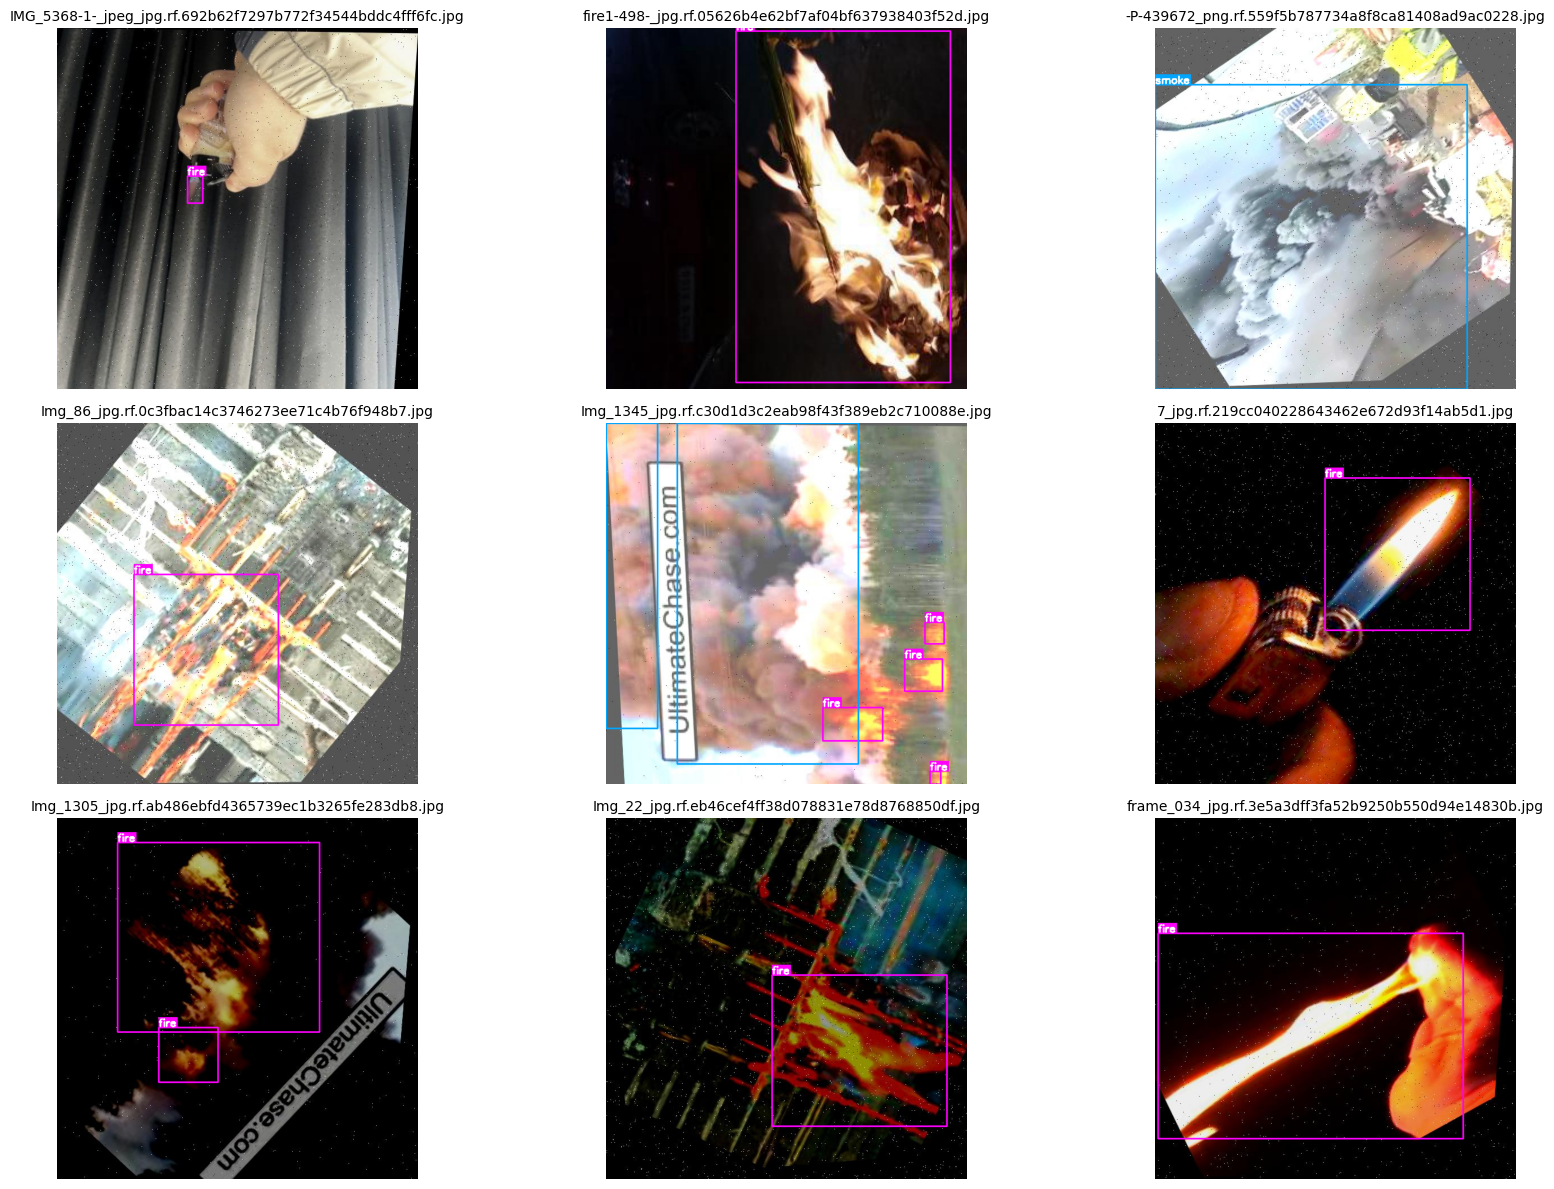

In [13]:
import random
import cv2
import matplotlib.pyplot as plt


train_img_path = "/kaggle/working/fixed_dataset/train/images"
train_label_path = "/kaggle/working/fixed_dataset/train/labels"

sample_imgs = random.sample(os.listdir(train_img_path), 9)

def visualize_image(img_path, label_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    
    label_file = os.path.splitext(label_path)[0] + ".txt"
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f.readlines():
                cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                
                x1 = int((x_center - bw/2) * w)
                y1 = int((y_center - bh/2) * h)
                x2 = int((x_center + bw/2) * w)
                y2 = int((y_center + bh/2) * h)

                if cls == 0:
                    cls_name = "fire"
                    color = (255, 0, 255) 
                else:
                    cls_name = "smoke"
                    color = (255, 165, 0) 

                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                (text_width, text_height), _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(img, (x1, y1 - text_height - 4), (x1 + text_width, y1), color, -1)
                cv2.putText(img, cls_name, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 12))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(train_img_path, img_name)
    label_path = os.path.join(train_label_path, img_name)
    plt.subplot(3, 3, i+1)
    plt.imshow(visualize_image(img_path, label_path))
    plt.axis('off')
    plt.title(img_name, fontsize=10)
plt.tight_layout()
plt.show()


In [14]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 105.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88

In [16]:
from ultralytics import YOLO

model = YOLO("yolo11m.pt") 

results = model.train(
    data="/kaggle/working/data.yaml",
    epochs=70,
    imgsz=640,
    batch=16,
    patience=15,       
    cls=2.0,
    optimizer='auto',
    cos_lr=True,              
    hsv_h=0.015,              
    degrees=0.0,              
    mosaic=1.0,
    mixup=0.15,               
    
    plots=True,
    save=True,
    project="/kaggle/working/runs/detect",
    name="fire_smoke_detection"
)

print("Training Finished!")

Ultralytics 8.3.232 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fire_smoke_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        872       1516      0.806      0.745       0.78      0.503
                  Fire        745       1116      0.834      0.823      0.841      0.531
                 Smoke        274        400      0.779      0.667      0.719      0.476
Speed: 0.2ms preprocess, 12.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/fire_smoke_detection
Training Finished!


In [17]:
from zipfile import ZipFile
from IPython.display import FileLink, display

folders_to_zip = [
    "/kaggle/working/runs/detect/fire_smoke_detection"
]

zip_filename = "/kaggle/working/fire_project_export.zip"

with ZipFile(zip_filename, 'w') as zipf:
    for folder in folders_to_zip:
        folder_path = Path(folder)
        for file in folder_path.rglob("*"):
            zipf.write(file, arcname=file.relative_to(folder_path.parent))

print(f"Zip file created: {zip_filename}")

display(FileLink(zip_filename))



Zip file created: /kaggle/working/fire_project_export.zip


/kaggle/working/fire_project_export.zip